正規化(画素値を255で割って0~1に収める)をした方が学習がうまくいきやすい。

ニューラルネットワークへの入力はベクトルでないといけない。<br>
画像の場合は行列やテンソルで表されているため、変換が必要。

行ごとに切り出して繋げ、行ベクトルにする。<br>
chainerのMNISTデータセットはすでにベクトル化されている。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import chainer
import chainer.functions as F #パラメータを含まない関数を収録
import chainer.links as L #パラメータを含む関数を収録
from chainer import computational_graph #グラフ出力用
from chainer import  serializers #モデルの保存と読み込み

/Users/zukako/.pyenv/versions/anaconda3-4.0.0/envs/chainer2_py35/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='.')

In [3]:
X=mnist.data
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [4]:
y=mnist.target
y

array([0., 0., 0., ..., 9., 9., 9.])

chainerは**32bit**型のみを受け付けるので、dtypeを変更する必要がある

In [5]:
X=X.astype(np.float32)
y=y.astype(np.int32)

In [6]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
y

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [8]:
X/=255.

In [9]:
X.max()

1.0

In [10]:
X.shape 
#784次元のベクトルが70000個
# もし２次元なら(70000,28,28)になる。

(70000, 784)

In [11]:
y.shape

(70000,)

DeepLearningでは**ホールドアウト法**を行う。
クロスバリデーションはコストがかかりすぎる。

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [13]:
X_train.shape

(49000, 784)

In [14]:
y_test.shape

(21000,)

In [17]:
# ニューラルネットワークの定義
# 4層のDeep Neural Network
# chainerのChainクラスを継承
class MLP(chainer.Chain):
    #ニューラルネットの構造(ノード間の関係)を定義
    #5層だったらLink数は4
    def __init__(self):
        super(MLP,self).__init__()
        with self.init_scope():
            self.l1=L.Linear(784,900)
            self.l2=L.Linear(900,1000)
            self.l3=L.Linear(1000,500)
            self.l4=L.Linear(500,10) #最後はクラスの数
            
    def __call__(self,X):
        #一層目(入力層)は単純にXが入力になっているので無視
        h1=F.relu(self.l1(X)) #2層目のノードにおける活性化関数/Xをl1に渡した結果900次元になったものをactivationにかける。
        h2=F.relu(self.l2(h1))
        h3=F.relu(self.l3(h2))
        return self.l4(h3)

### 出力層はsoftmax関数を用いる
ネットワークの出力は大きさがバラバラであり、マイナスの値を取りうる。<br>
教師データは正の数であり合計が１である。<br>
出力と単純比較するには同じ性質を持つ必要がある。<br>
指数関数はどんな入力でもプラスに変換する<br>
さらに大きな数値が入るほど大きな値を返すので、大小関係を維持している。

softmax_cross_entropy：正解ラベルに確信を持てた度合いが大きいほど最適化される

### 確率的勾配降下法
- バッチ学習ではデータのサンプリングを行わないので誤差関数が毎回同じ=**最急降下法**と呼ぶ
- バッチ学習、ミニバッチ学習はデータのサンプリングを行うため、サンプリングのたびに誤差関数が変わる=**確率的勾配降下法(SGD)**と呼ぶ

In [18]:
# 分類器インスタンスの生成
# MLPクラスのインスタンスを引数として渡す
model = L.Classifier(MLP())

In [19]:
from chainer.datasets import tuple_dataset
from chainer import iterators,training
from chainer.training import extensions

In [20]:
#trainデータをtuple_datasetというchainer独自の型に変換
train=tuple_dataset.TupleDataset(X_train,y_train)

In [28]:
#train_iter
batch_size=100
train_iter=iterators.SerialIterator(train,batch_size=batch_size,shuffle=True)

In [22]:
# optimizerの定義 setupしないといけない
optimizer = chainer.optimizers.SGD()  # 今回はSGDを利用
optimizer.setup(model)                # モデルを読み込ませる

In [23]:
updater=training.StandardUpdater(train_iter,optimizer=optimizer,device=-1)

In [26]:
n_epoch=20
trainer=training.Trainer(updater,(n_epoch,'epoch'),out='result')

test制度の評価のためのevaluator(Extensions)

In [27]:
#独自の型変換
test=tuple_dataset.TupleDataset(X_test,y_test)

In [29]:
test_iter=iterators.SerialIterator(test,batch_size=batch_size,shuffle=False,repeat=False)

In [30]:
# Evaluatorクラスをtrainerに登録しておく
trainer.extend(extensions.Evaluator(test_iter, model))

In [31]:
# ログファイルを作成する機能を追加
trainer.extend(extensions.LogReport())

In [32]:
# 学習状況の報告を逐一出力する機能を追加
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss','validation/main/accuracy']))

In [33]:
#学習終了時に
# trainとtestの精度のグラフを出力
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
                          'epoch', file_name='accuracy.png'))
# trainとtestの損失関数のグラフを出力
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))

In [34]:
# 指定した内容で学習を実行
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy
1           1.28267     0.717694       0.565492              0.854952                  
2           0.444403    0.881918       0.373756              0.895048                  
3           0.337878    0.905469       0.317172              0.909762                  
4           0.293316    0.916102       0.282113              0.917                     
5           0.264703    0.923857       0.26108               0.92419                   
6           0.242308    0.931204       0.24181               0.930095                  
7           0.224564    0.935041       0.230531              0.933619                  
8           0.208352    0.939469       0.214609              0.937524                  
9           0.194767    0.944041       0.201997              0.940762                  
10          0.182178    0.948408       0.193995              0.943381                  
11          0.17083     0.950878  

In [35]:
serializers.save_npz('mnist.model',model)

In [39]:
serializers.load_npz('mnist.model', model_reloaded)

In [38]:
model_reloaded= L.Classifier(MLP())

In [57]:
model_reloaded.predictor(X[0].reshape(1,-1)).data.argmax(axis=1)

array([0])

In [60]:
model_reloaded.predictor(X[0].reshape(1,-1)).data #predictorの出力はそもそもなんだ？

array([[12.007708  , -5.1732254 ,  3.7551577 , -1.5096596 , -6.3048315 ,
        -0.1851458 , -1.1101662 ,  0.11618298, -0.6267059 ,  1.3251595 ]],
      dtype=float32)

In [62]:
model_reloaded.predictor(X[0].reshape(1,-1))

variable([[12.007708  , -5.1732254 ,  3.7551577 , -1.5096596 ,
           -6.3048315 , -0.1851458 , -1.1101662 ,  0.11618298,
           -0.6267059 ,  1.3251595 ]])

In [58]:
model_reloaded.predictor(X[0].reshape(1,-1)).argmax(axis=1)

AttributeError: 'Variable' object has no attribute 'argmax'

In [50]:
def draw_digit(data):
    """数値の行列データを画像表示"""
    plt.figure(figsize=(3, 3))
    X, Y = np.meshgrid(range(28),range(28))
    Z = data.reshape(28, 28)
    Z = Z[::-1,:]
    plt.pcolor(X, Y, Z)
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")
    plt.gray()
    plt.show()

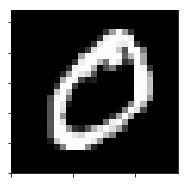

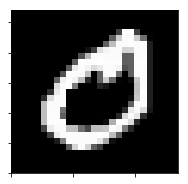

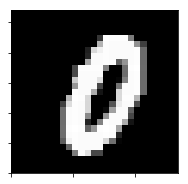

In [54]:
draw_digit(X[0])
draw_digit(X[1])
draw_digit(X[2])